# Filtering internal tide 

This notebook aims at removing internal tide from Internal Ground Waves (IGW) signal **ssh_igw**. A bandpass filter around tidal frequency (12 hours) is applied.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.fftpack as fp
#from scipy.interpolate import RegularGridInterpolator, griddata
from joblib import Parallel
from joblib import delayed as jb_delayed
from pyinterp import fill, Axis, TemporalAxis, Grid3D, Grid2D
from math import *

In [2]:
ask_workers = 32

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=ask_workers,dashboard_address=':8686')
c = Client(cluster)
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8686/status,
Dashboard: http://127.0.0.1:8686/status,Workers: 32
Total threads: 32,Total memory: 187.54 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43827,Workers: 32
Dashboard: http://127.0.0.1:8686/status,Total threads: 32
Started: Just now,Total memory: 187.54 GiB
Comm: tcp://127.0.0.1:35355,Total threads: 1
Dashboard: http://127.0.0.1:35973/status,Memory: 5.86 GiB
Nanny: tcp://127.0.0.1:43585,


## 1. - Data import 

In [3]:
ds = xr.open_mfdataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_201206*.nc",combine='nested',concat_dim='time',parallel=True)

In [4]:
ssh_igw = ds.ssh_igw.load()

In [5]:
array_ssh_igw = ssh_igw.values

## 2. - Internal tide extraction 

In [6]:
array_time = ssh_igw.time.values
nt = array_time.size

In [13]:
# PARAMETERS # 
wint = np.ones(3*nt)
gaspari = gaspari_cohn(np.arange(0,2*nt,1),nt,nt)
wint[:nt]=gaspari[:nt]
wint[2*nt:]=gaspari[nt:]

dt = 3600 # seconds

w = fp.fftfreq(3*nt,dt)# seconds^-1
nw = w.size

w1 = 1/15/3600
w2 = 1/9/3600
H = (np.abs(w)>w1) & (np.abs(w)<w2)
w_filtered = H*w

In [14]:

array_ssh_igw_flat = array_ssh_igw.reshape((720,1681*3121))

In [15]:
idx_ocean = np.where(np.invert(np.isnan(array_ssh_igw[0,:,:]))) # indexes of ocean pixels 

In [16]:
# PROCESSING # 
ssh_it_flat = np.array(Parallel(n_jobs=24,backend='multiprocessing')(jb_delayed(extract_it)(array_ssh_igw[:,i,j],wint,H) for i,j in zip(idx_ocean[0],idx_ocean[1])))

In [17]:
# ARRAY TO STORE THE RESULTS # 
array_ssh_it = np.nan*np.ones_like(array_ssh_igw,dtype="float64")
array_ssh_it[:,idx_ocean[0],idx_ocean[1]]=ssh_it_flat.T
#np.save(file="/bettik/bellemva/MITgcm/ssh_it.npy",arr=array_ssh_it)

Saving internal tide **ssh_it** into xarray DataArray files. 

In [ ]:
array_ssh_it=np.load("/bettik/bellemva/MITgcm/ssh_it.npy")

In [18]:
date_array = np.arange(np.datetime64("2012-06-01"),np.datetime64("2012-07-01"))

for i in range (len(date_array)) : 
    ds = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_"+date_array[i].astype('str').replace('-','')+".nc")
    ssh_igw = ds.ssh_igw
    ssh_it = ssh_igw.copy(data=array_ssh_it[i*24:(i+1)*24,:,:])
    ssh_it = ssh_it.rename("ssh_it")
    ssh_it.to_netcdf("/bettik/bellemva/MITgcm/MITgcm_it/MITgcm_it_"+date_array[i].astype('str').replace('-','')+".nc")
    print(date_array[i])
        

2012-06-01
2012-06-02
2012-06-03
2012-06-04
2012-06-05
2012-06-06
2012-06-07
2012-06-08
2012-06-09
2012-06-10
2012-06-11
2012-06-12
2012-06-13
2012-06-14
2012-06-15
2012-06-16
2012-06-17
2012-06-18
2012-06-19
2012-06-20
2012-06-21
2012-06-22
2012-06-23
2012-06-24
2012-06-25
2012-06-26
2012-06-27
2012-06-28
2012-06-29
2012-06-30


## 3. - Internal tide analysis 

In [2]:
import xrft

In [70]:
ds = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_it/MITgcm_it_20120605.nc")
ssh_it = ds.ssh_it.load()#.sel(longitude = slice(210,230),latitude=slice(10,30))

STUDYING POWERSPECTRUM OF INTERNAL TIDES WITH DIFFERENT LATITUDES

In [31]:
# CREATING THE DIFFERENT DATASETS #
ssh_it_15 = ssh_it.sel(longitude = slice(190,200),latitude=slice(10,20))
ssh_it_20 = ssh_it.sel(longitude = slice(190,200),latitude=slice(15,25))
ssh_it_25 = ssh_it.sel(longitude = slice(190,200),latitude=slice(20,30))
ssh_it_30 = ssh_it.sel(longitude = slice(190,200),latitude=slice(25,35))
ssh_it_35 = ssh_it.sel(longitude = slice(190,200),latitude=slice(30,40))
ssh_it_40 = ssh_it.sel(longitude = slice(190,200),latitude=slice(35,45))

cart_ssh_it_15 = interpolate_ssh_it(ssh_it_15)
cart_ssh_it_20 = interpolate_ssh_it(ssh_it_20)
cart_ssh_it_25 = interpolate_ssh_it(ssh_it_25)
cart_ssh_it_30 = interpolate_ssh_it(ssh_it_30)
cart_ssh_it_35 = interpolate_ssh_it(ssh_it_35)
cart_ssh_it_40 = interpolate_ssh_it(ssh_it_40)


In [34]:
res_15 = xrft.isotropic_power_spectrum(cart_ssh_it_15,dim=['x','y']).mean(["time"])
res_20 = xrft.isotropic_power_spectrum(cart_ssh_it_20,dim=['x','y']).mean(["time"])
res_25 = xrft.isotropic_power_spectrum(cart_ssh_it_25,dim=['x','y']).mean(["time"])
res_30 = xrft.isotropic_power_spectrum(cart_ssh_it_30,dim=['x','y']).mean(["time"])
res_35 = xrft.isotropic_power_spectrum(cart_ssh_it_35,dim=['x','y']).mean(["time"])
res_40 = xrft.isotropic_power_spectrum(cart_ssh_it_40,dim=['x','y']).mean(["time"])

/home/bellemva/miniconda3/envs/pangeo-forge/lib/python3.10/site-packages/xrft/xrft.py:1025: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/home/bellemva/miniconda3/envs/pangeo-forge/lib/python3.10/site-packages/xrft/xrft.py:1025: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/home/bellemva/miniconda3/envs/pangeo-forge/lib/python3.10/site-packages/xrft/xrft.py:1025: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/home/bellemva/miniconda3/envs/pangeo-forge/lib/python3.10/site-packages/xrft/xrft.py:1025: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/home/bellemva/miniconda3/envs/pangeo-forge/lib/python3.10/site-packages/xrft/xrft.py:1025: FutureWarning: Isotropic wavenumber larger than the Nyquist wave

(0.05, 0.0)

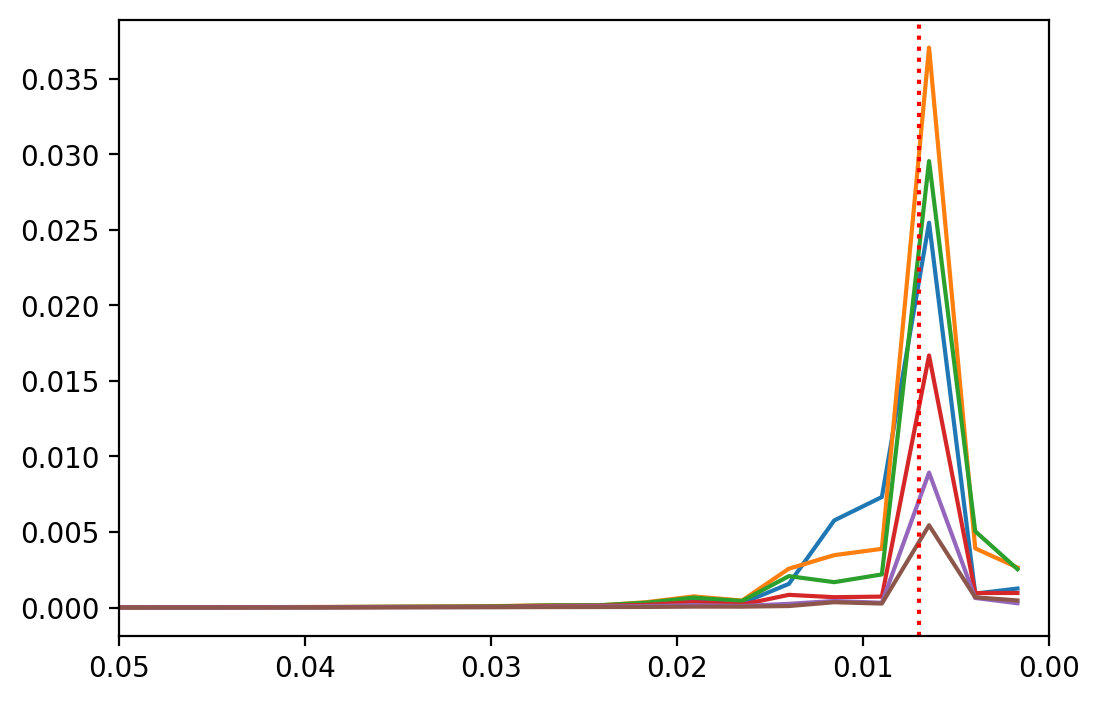

In [49]:
fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=200)

ax.plot(res_15.freq_r.values,res_15.values,label="15°")
ax.plot(res_20.freq_r.values,res_20.values,label="20°")
ax.plot(res_25.freq_r.values,res_25.values,label="25°")
ax.plot(res_30.freq_r.values,res_30.values,label="30°")
ax.plot(res_35.freq_r.values,res_35.values,label="35°")
ax.plot(res_40.freq_r.values,res_40.values,label="40°")

ax.axvline(0.007,c='red',linestyle=':')

ax.set_xlim(0.05,0)

STUDYING POWERSPECTRUM OF INTERNAL TIDES IN TWO BOXES (HAWAI AND DEEP OCEAN)

In [58]:
ssh_it_hawai = ssh_it.sel(longitude = slice(185,205),latitude=slice(15,35))
ssh_it_dpo = ssh_it.sel(longitude = slice(210,230),latitude=slice(10,30))

cart_ssh_it_hawai = interpolate_ssh_it(ssh_it_hawai)
cart_ssh_it_dpo = interpolate_ssh_it(ssh_it_dpo)

res_hawai = xrft.isotropic_power_spectrum(cart_ssh_it_hawai,dim=['x','y']).mean(["time"])
res_dpo = xrft.isotropic_power_spectrum(cart_ssh_it_dpo,dim=['x','y']).mean(["time"])

1112
1112


/home/bellemva/miniconda3/envs/pangeo-forge/lib/python3.10/site-packages/xrft/xrft.py:1025: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/home/bellemva/miniconda3/envs/pangeo-forge/lib/python3.10/site-packages/xrft/xrft.py:1025: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)


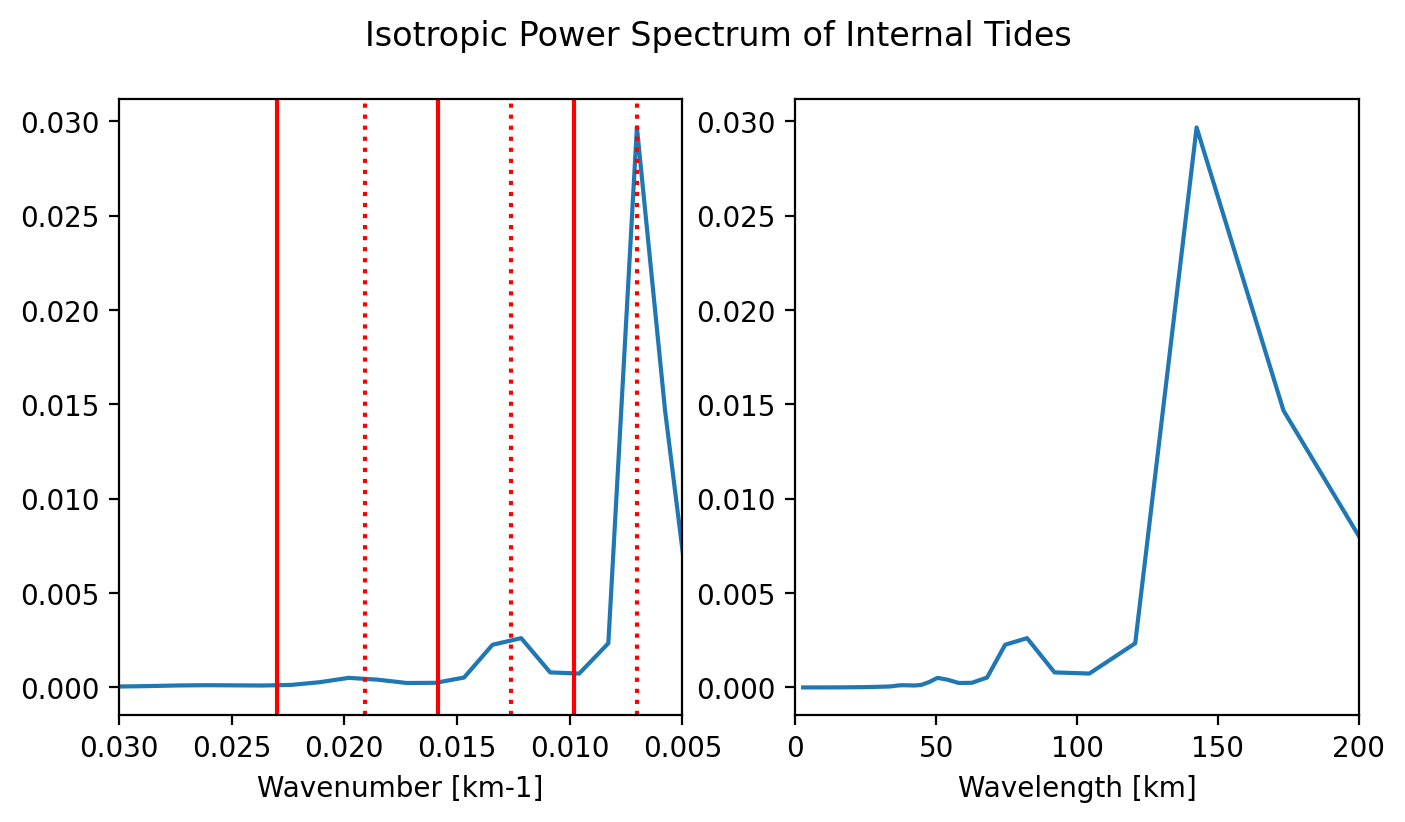

In [63]:
plot_spectrum(res_hawai)

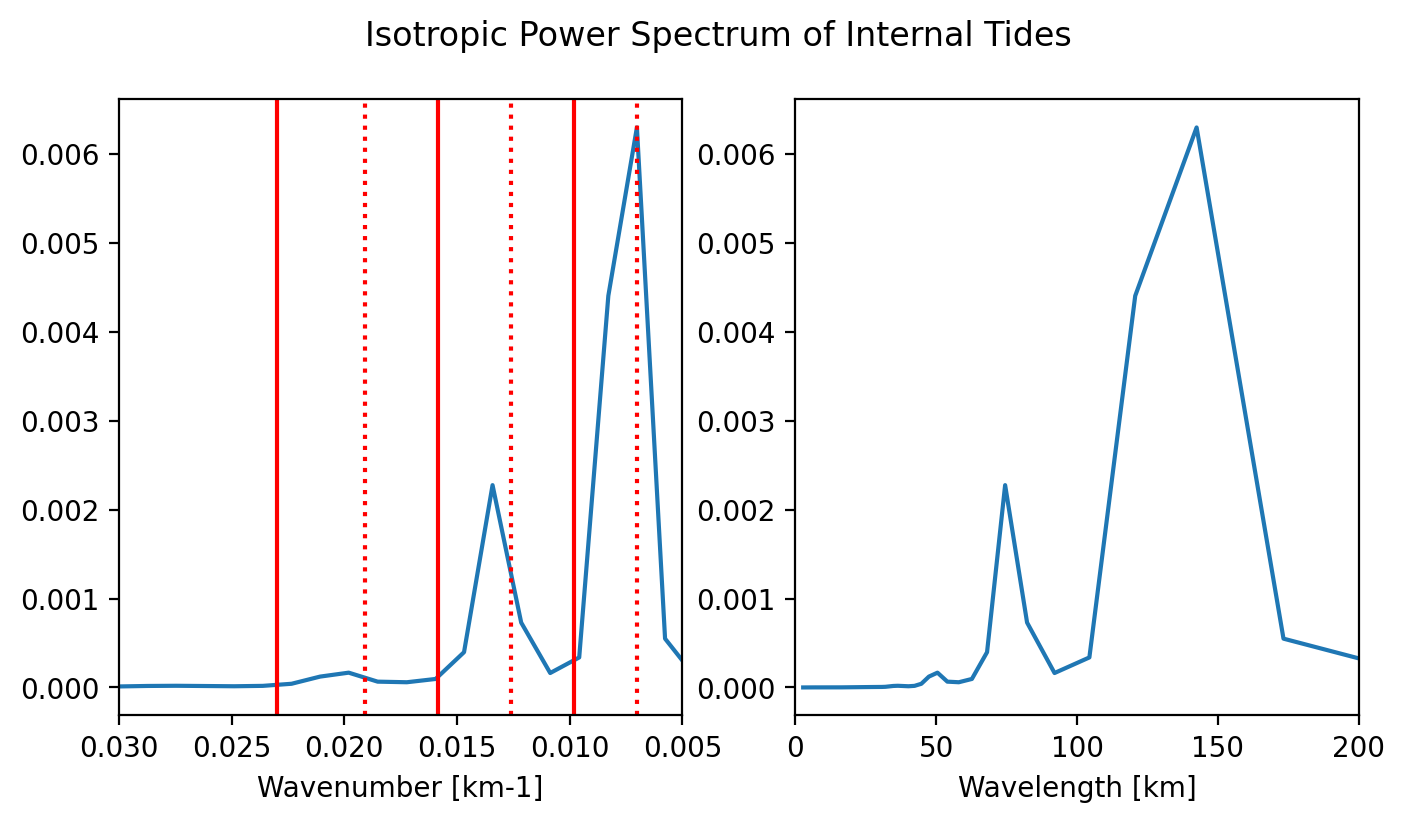

In [64]:
plot_spectrum(res_dpo)

In [71]:
plt.pcolormesh(ssh_it.longitude.values, ssh_it.latitude.values,ds.ssh_igw.values[0],
               vmin=-0.1,vmax=0.1,cmap="RdBu")

AttributeError: 'Dataset' object has no attribute 'ssh_igw'

In [76]:
ds = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_20120605.nc")
ds

<xarray.Dataset>
Dimensions:      (latitude: 1681, longitude: 3121, time: 24)
Coordinates:
  * latitude     (latitude) float32 10.0 10.02 10.04 10.06 ... 44.96 44.98 45.0
  * longitude    (longitude) float32 180.0 180.0 180.0 ... 245.0 245.0 245.0
  * time         (time) datetime64[ns] 2012-06-05 ... 2012-06-05T23:00:00
Data variables:
    mask         (time, latitude, longitude) bool ...
    ssh_bar      (time, latitude, longitude) float64 ...
    ssh_bar_600  (time, latitude, longitude) float64 ...
    ssh_bm       (time, latitude, longitude) float64 ...
    ssh_dedac    (time, latitude, longitude) float32 ...
    ssh_hf       (time, latitude, longitude) float64 ...
    ssh_cor      (time, latitude, longitude) float64 ...
    ssh_igw      (time, latitude, longitude) float64 ...
    ssh_it       (time, latitude, longitude) float64 ...
Attributes:
    NCO:      netCDF Operators version 4.9.8 (Homepage = http://nco.sf.net, C...
    history:  Wed May 24 17:35:52 2023: ncap2 -A -s ssh_igw=ssh_hf-ssh_bar_60...

In [92]:
ssh_it.latitude.values

array([10.      , 10.020833, 10.041667, ..., 44.958332, 44.979168,
       45.      ], dtype=float32)

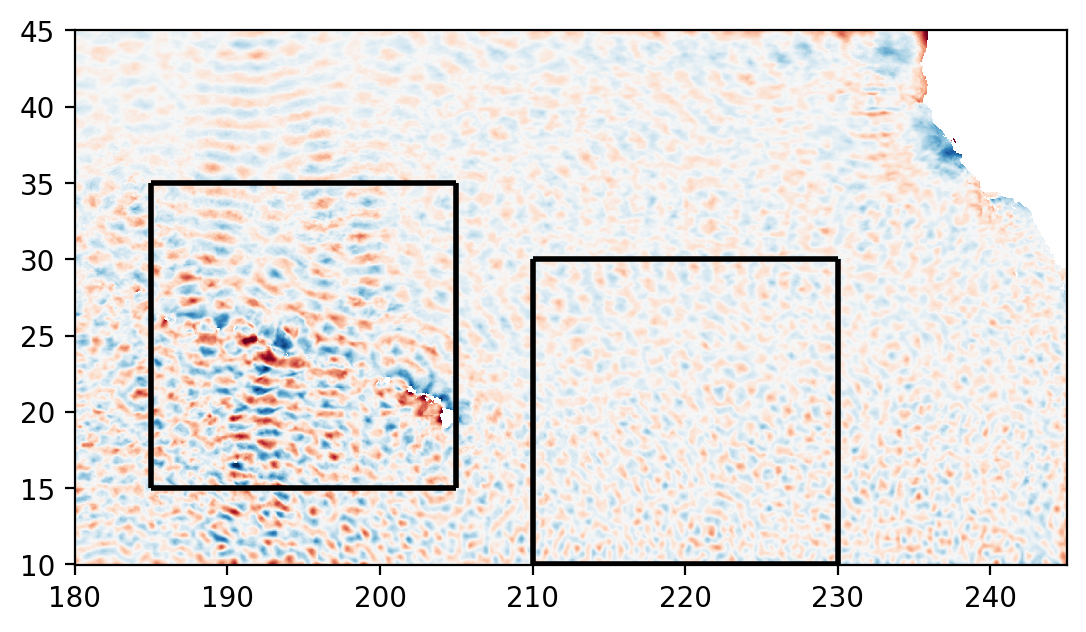

In [100]:
fig,ax = plt.subplots(1,1,dpi=200)
ax.pcolormesh(ssh_it.longitude.values, ssh_it.latitude.values,ds.ssh_it.values[0],
               vmin=-0.1,vmax=0.1,cmap="RdBu")
ax.set_aspect("equal")

ax.vlines(x=[185,205,210,230],ymin=[15,15,10,10],ymax=[35,35,30,30],colors='black',lw=2)
ax.hlines(y=[15,35,10,30],xmin=[185,185,210,210],xmax=[205,205,230,230],colors='black',lw=2)


## Functions 

In [8]:
def extract_it(array_ssh,wint,H): 
    ssh_extended = np.concatenate((np.flip(array_ssh),
                                   array_ssh,
                                   np.flip(array_ssh)))
    ssh_win = wint * ssh_extended 
    ssh_f_t = fp.fft(ssh_win)
    ssh_f_filtered =  H * ssh_f_t
    ssh_filtered = np.real(fp.ifft(ssh_f_filtered))[nt:2*nt]
    return ssh_filtered

In [9]:
def gaspari_cohn(array,distance,center):
    """
    NAME 
        bfn_gaspari_cohn

    DESCRIPTION 
        Gaspari-Cohn function. @vbellemin.
        
        Args: 
            array : array of value whose the Gaspari-Cohn function will be applied
            center : centered value of the function 
            distance : Distance above which the return values are zeros


        Returns:  smoothed values 
            
    """ 
    if type(array) is float or type(array) is int:
        array = np.array([array])
    else:
        array = array
    if distance<=0:
        return np.zeros_like(array)
    else:
        array = 2*np.abs(array-center*np.ones_like(array))/distance
        gp = np.zeros_like(array)
        i= np.where(array<=1.)[0]
        gp[i]=-0.25*array[i]**5+0.5*array[i]**4+0.625*array[i]**3-5./3.*array[i]**2+1.
        i =np.where((array>1.)*(array<=2.))[0]
        gp[i] = 1./12.*array[i]**5-0.5*array[i]**4+0.625*array[i]**3+5./3.*array[i]**2-5.*array[i]+4.-2./3./array[i]
        #if type(r) is float:
        #    gp = gp[0]
    return gp

In [10]:
def create_cartesian_grid (latitude,longitude,dx):
    """ 
    Creates a cartesian grid (regular in distance, kilometers) from a geodesic latitude, longitude grid. 
    The new grid is expressed in latitude, longitude coordinates.

    Parameters
    ----------
    longitude : numpy ndarray 
        Vector of longitude for geodesic input grid. 
    latitude : numpy ndarray 
        Vector of latitude for geodesic input grid. 
    dx : float 
        Grid spacing in kilometers. 

    Returns
    -------
    ENSLAT2D : 
        2-D numpy ndarray of the latitudes of the points of the cartesian grid 
    ENSLON2D : 
        2-D numpy ndarray of the longitudes of the points of the cartesian grid 
    """
    km2deg = 1/111

    # ENSEMBLE OF LATITUDES # 
    ENSLAT = np.arange(latitude[0],latitude[-1]+dx*km2deg,dx*km2deg)
    range_lon = longitude[-1]-longitude[0]

    if longitude.size%2 == 0 : 
        nstep_lon = floor(range_lon/(dx*km2deg))+2
    else : 
        nstep_lon = ceil(range_lon/(dx*km2deg))+2
    ENSLAT2D = np.repeat(np.expand_dims(ENSLAT,axis=1),axis=1,repeats=nstep_lon)

    # ENSEMBLE OF LATITUDES # 
    mid_lon = (longitude[-1]+longitude[0])/2
    ENSLON2D=np.zeros_like(ENSLAT2D)

    for i in range(len(ENSLAT)):
        d_lon = dx*km2deg*(np.cos(np.pi*ENSLAT[0]/180)/np.cos(np.pi*ENSLAT[i]/180))
        d_lon_range = np.array([i*d_lon for i in range (1,int(nstep_lon/2)+1)])
        lon_left = np.flip(mid_lon-d_lon_range)
        lon_right = mid_lon+d_lon_range
        ENSLON2D[i,:]=np.concatenate((lon_left,lon_right))

    return ENSLAT2D, ENSLON2D, ENSLAT2D.shape[0], ENSLAT2D.shape[1]
    

In [11]:
def interpolate_ssh_it(ssh_it):

    x_axis = Axis(ssh_it.longitude.values,is_circle=True)
    y_axis = Axis(ssh_it.latitude.values,is_circle=True)
    t_axis = TemporalAxis(ssh_it.time.values)

    grid = Grid3D(y_axis, x_axis, t_axis, ssh_it.values.transpose(1,2,0))
    has_converged, filled = fill.gauss_seidel(grid,num_threads=4)

    ssh_it_filled = ssh_it.copy(deep=True,data=filled.transpose(2,0,1)).chunk({'time':1})

    dx = 2 # in kilometers, spacing of the grid 

    ENSLAT2D, ENSLON2D, i_lat, i_lon = create_cartesian_grid(ssh_it_filled.latitude.values,
                                                            ssh_it_filled.longitude.values,
                                                            dx)

    array_cart_ssh = ssh_it_filled.interp(latitude=('z',ENSLAT2D.flatten()),
                                        longitude=('z',ENSLON2D.flatten()),
                                        ).values

    # INTERPOLATION OF NaNs # 
    x_axis = Axis(np.arange(i_lon))
    y_axis = Axis(np.arange(i_lat))
    t_axis = TemporalAxis(ssh_it.time.values)

    grid = Grid3D(y_axis, x_axis, t_axis, array_cart_ssh.reshape((24,i_lat,i_lon)).transpose(1,2,0))
    has_converged, filled = fill.gauss_seidel(grid,num_threads=4)


    # CREATION OF DataArray #
    cart_ssh_it = xr.DataArray(data=filled.transpose(2,0,1),
                            dims=["time","y","x"],
                            coords = dict(
                                time = ssh_it_filled.time.values,
                                #y=(["y"],np.arange(i_lat)),
                                #x=(["x"],np.arange(i_lon))
                                y=np.array([i*dx for i in range (i_lat)]),
                                x=np.array([i*dx for i in range (i_lon)])
                            )).chunk({'time':1})
    
    return cart_ssh_it


In [12]:
def plot_spectrum(res):
    
    fig, ax = plt.subplots(1,2,figsize=(8,4),dpi=200)

    k1 = 0.0070
    k2 = 0.0126
    k3 = 0.0191
    k4 = 0.0269

    ax[0].plot(res.freq_r.values,res.values)
    ax[0].set_xlim(0.03,0.005)
    ax[0].set_xlabel("Wavenumber [km-1]")
    ax[0].axvline(k1,c='red',linestyle=':')
    ax[0].axvline(k2,c='red',linestyle=':')
    ax[0].axvline(k3,c='red',linestyle=':')
    ax[0].axvline((k1+k2)/2,c='red',linestyle='-')
    ax[0].axvline((k2+k3)/2,c='red',linestyle='-')
    ax[0].axvline((k3+k4)/2,c='red',linestyle='-')


    ax[1].plot(1/res.freq_r.values,res.values)
    ax[1].set_xlim(0,200)
    ax[1].set_xlabel("Wavelength [km]")

    fig.suptitle("Isotropic Power Spectrum of Internal Tides")